## Overview

In this notebook, we explore the movie rating data.
This notebook uses the movie rating data that was retrieved from BigInsights and saved to DSX local storage by the previous notebook.

If you have skipped the previous steps, uncomment and run the following code to start at Step 4

In [1]:
# !rm -rf ml-1m.zip ml-1m
# !wget --quiet http://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip
# !mv ml-1m/ratings.dat .

## Load rating data

Again, let's check the structure of the data ...

In [2]:
!head -3 ratings.dat
!echo
!tail -3 ratings.dat

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968

6040::562::5::956704746
6040::1096::4::956715648
6040::1097::4::956715569


Ok, so we should have:

`UserID::MovieID::Rating::Timestamp`

Now load the data into a RDD:

In [3]:
from pyspark.mllib.recommendation import Rating

ratingsRDD = sc.textFile('ratings.dat') \
               .map(lambda l: l.split("::")) \
               .map(lambda p: Rating(
                                  user = int(p[0]), 
                                  product = int(p[1]),
                                  rating = float(p[2]), 
                                  )).cache()

It's useful to check some highlevel statistics on the data.  For example, we can see that ratings are between 1.0 and 5.0

In [4]:
ratingsRDD.toDF().describe().show()

+-------+------------------+------------------+------------------+
|summary|              user|           product|            rating|
+-------+------------------+------------------+------------------+
|  count|           1000209|           1000209|           1000209|
|   mean| 3024.512347919285|1865.5398981612843| 3.581564453029317|
| stddev|1728.4126948999951|1096.0406894572552|1.1171018453732544|
|    min|                 1|                 1|               1.0|
|    max|              6040|              3952|               5.0|
+-------+------------------+------------------+------------------+



## Explore the data

First we we zoom in to visualize the ratings for a subset of users (user id < 10 and movie id < 20). We should see a sparse matrix.  
After that, we can zoom back out to look at the ratings for all of the users across all of the movies.

### Visualise the ratings matrix using a subset of the data

Let's take a subset of the data

In [5]:
ratings = ratingsRDD.filter(lambda x: x.user < 10 and x.product < 20).toDF()

Separate the x (user) values and also the y (movie) values for matplotlib.<br>
Also normalise the rating value so that it is between 0 and 1.  This is required for coloring the markers.

In [6]:
from pyspark.sql.functions import min, max

user = ratings.map(lambda x: int(x.user)).cache()
movie = ratings.map(lambda x: int(x.product)).cache()

min_r = ratings.select(min('rating')).take(1)[0]['min(rating)']
max_r = ratings.select(max('rating')).take(1)[0]['max(rating)']

def normalise(x):
    rating = (x - min_r) / (max_r - min_r)
    return float(rating)

ratingN = ratings.map(lambda x: normalise(x.rating)).cache()

We can now plot the sparse matrix of ratings for this subset of users and movies.

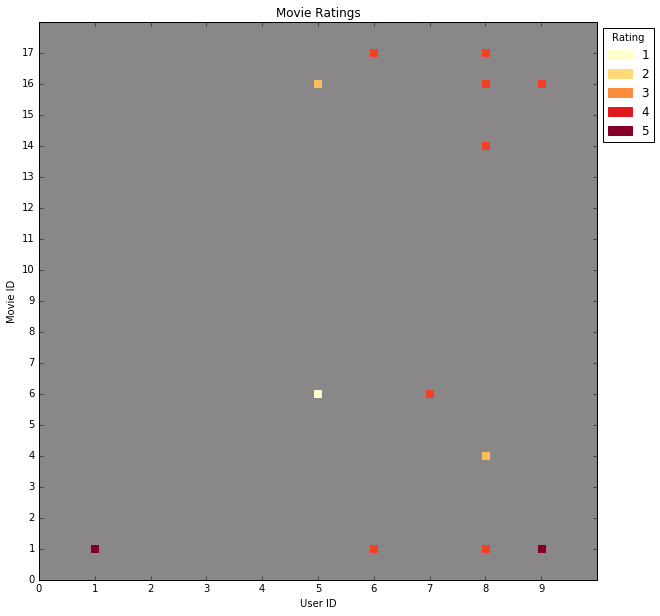

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

min_user = ratings.select(min('user')).take(1)[0]['min(user)']
max_user = ratings.select(max('user')).take(1)[0]['max(user)']
min_movie = ratings.select(min('product')).take(1)[0]['min(product)']
max_movie = ratings.select(max('product')).take(1)[0]['max(product)']

width = 10
height = 10
plt.figure(figsize=(width, height))
plt.xlim([min_user-1,max_user+1])
plt.ylim([min_movie-1,max_movie+1])
plt.xticks(np.arange(min_user-1, max_user+1, 1))
plt.yticks(np.arange(min_movie-1, max_movie+1, 1))
plt.xlabel('User ID')
plt.ylabel('Movie ID')
plt.title('Movie Ratings')

ax = plt.gca()
ax.patch.set_facecolor('#898787') # dark grey background

colors = plt.cm.YlOrRd(ratingN.collect())

plt.scatter(
    user.collect(), 
    movie.collect(), 
    s=50,
    marker="s",
    color=colors,
    edgecolor=colors)

plt.legend(
    title='Rating',
    loc="upper left", 
    bbox_to_anchor=(1,1),
    handles=[
        mpatches.Patch(color=plt.cm.YlOrRd(0),    label='1'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.25), label='2'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.5),  label='3'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.75), label='4'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.99), label='5')    
    ])

plt.show()

In the plot, you can see the ratings color code.  For example User 1 has rated movie 1 with the highest rating of 5.<br>
Let's dump the dataset to double check ...

In [8]:
ratings.collect()

[Row(user=1, product=1, rating=5.0),
 Row(user=5, product=6, rating=2.0),
 Row(user=5, product=16, rating=3.0),
 Row(user=6, product=1, rating=4.0),
 Row(user=6, product=17, rating=4.0),
 Row(user=7, product=6, rating=4.0),
 Row(user=8, product=1, rating=4.0),
 Row(user=8, product=4, rating=3.0),
 Row(user=8, product=14, rating=4.0),
 Row(user=8, product=16, rating=4.0),
 Row(user=8, product=17, rating=4.0),
 Row(user=9, product=1, rating=5.0),
 Row(user=9, product=16, rating=4.0)]

The plot is as expected, so we can repeat this with the full data set.

### Visualise the ratings matrix using the full data set

This time we don't need to filter the RDD

In [9]:
ratings = ratingsRDD.toDF()

Same functions as before ...

In [10]:
from pyspark.sql.functions import min, max

user = ratings.map(lambda x: int(x.user)).cache()
movie = ratings.map(lambda x: int(x.product)).cache()

min_r = ratings.select(min('rating')).take(1)[0]['min(rating)']
max_r = ratings.select(max('rating')).take(1)[0]['max(rating)']

def normalise(x):
    rating = (x - min_r) / (max_r - min_r)
    return float(rating)

ratingN = ratings.map(lambda x: normalise(x.rating)).cache()

Slighly modified chart, for example to print out smaller markers

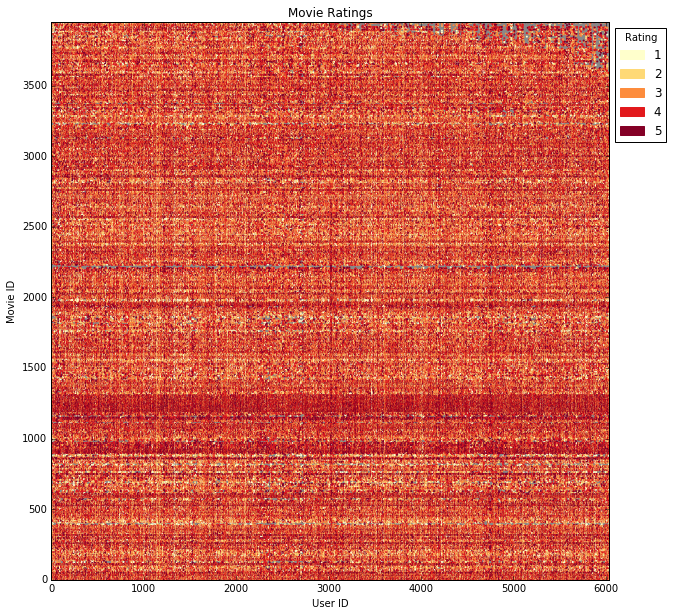

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

max_user = ratings.select(max('user')).take(1)[0]['max(user)']
max_movie = ratings.select(max('product')).take(1)[0]['max(product)']

width = 10
height = 10
plt.figure(figsize=(width, height))
plt.xlim([0,max_user])
plt.ylim([0,max_movie])
plt.xlabel('User ID')
plt.ylabel('Movie ID')
plt.title('Movie Ratings')

ax = plt.gca()
ax.patch.set_facecolor('#898787') # dark grey background

colors = plt.cm.YlOrRd(ratingN.collect())

plt.scatter(
    user.collect(), 
    movie.collect(), 
    s=1,
    edgecolor=colors)

plt.legend(
    title='Rating',
    loc="upper left", 
    bbox_to_anchor=(1,1),
    handles=[
        mpatches.Patch(color=plt.cm.YlOrRd(0),    label='1'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.25), label='2'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.5),  label='3'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.75), label='4'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.99), label='5')    
    ])

plt.show()

We can see some clear patterns.  The horizontal lines indicate that users tend to rate movies similarily.<br>
The vertical lines could also indicate that a person ranks all movies fairly similarly - if a pale line, they tend to rate negatively and dark red positively.<br>
There are some interesting grey patterns too, where users have not rated movies.  Notice the grey arc at the top right of the plot.<br>
